# Training CycleGAN with Toyzero data

In [1]:
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
from collections import OrderedDict
import torch

from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
from configs.config import options 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## Options

In [20]:
config_file = './configs/config_toyzero_128x128_32_64.yaml'
opt = options(config_file)

opt.name = 'testtest'
opt.save_epoch_freq = 1

opt.print_options()

pt_folder = Path(opt.checkpoints_dir)/opt.name
print(f'pt_folder = {pt_folder}')
if not pt_folder.exists():
    pt_folder.mkdir(parents=True)

self.gpu_ids=[0]
self.checkpoints_dir=./checkpoints
self.model=cycle_gan
self.input_nc=1
self.output_nc=1
self.ngf=64
self.ndf=64
self.netD=basic
self.netG=resnet_9blocks
self.n_layers_D=3
self.norm=instance
self.init_type=normal
self.init_gain=0.02
self.no_dropout=True
self.dataset_mode=toyzero
self.direction=AtoB
self.serial_batches=False
self.num_threads=1
self.batch_size=32
self.load_size=286
self.crop_size=256
self.max_dataset_size=1000
self.preprocess=resize_and_crop
self.no_flip=False
self.display_winsize=256
self.epoch=latest
self.load_iter=0
self.verbose=False
self.suffix=
self.display_freq=400
self.display_ncols=4
self.display_id=1
self.display_server=http://localhost
self.display_env=main
self.display_port=8097
self.update_html_freq=1000
self.print_freq=100
self.no_html=False
self.save_latest_freq=5000
self.save_epoch_freq=1
self.save_by_iter=False
self.continue_train=False
self.epoch_count=1
self.phase=train
self.n_epochs=100
self.n_epochs_decay=100
self.beta1=0.5
self.lr=0

## Load training and validation dataset

In [21]:
# Load training dataset
dataset = create_dataset(opt)
print(f'The number of training images = {len(dataset)}')

dataset [ToyzeroDataset] was created
The number of training images = 1000


In [22]:
# Load aligned validation dataset
opt_valid = options(config_file)
opt_valid.dataset_mode = 'toyzero_aligned'
opt_valid.phase = 'test'
# let batch_size = max_dataset_size so that we don't have 
# to iterate through the loader.
opt_valid.batch_size = 100 
opt_valid.max_dataset_size = 100
dataset_valid = create_dataset(opt_valid)
print(f'The number of validation images = {len(dataset_valid)}')
dataset_valid = next(iter(dataset_valid))

dataset [ToyzeroAlignedDataset] was created
The number of validation images = 100


## Load model

In [23]:
model = create_model(opt)      # create a model given opt.model and other options
model.setup(opt)   # regular setup: load and print networks; create schedulers

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.366 M
[Network G_B] Total number of parameters : 11.366 M
[Network D_A] Total number of parameters : 2.763 M
[Network D_B] Total number of parameters : 2.763 M
-----------------------------------------------


## Train

In [24]:
def get_validation_visuals(model, dataset_valid):
    with torch.no_grad():
        real_A = dataset_valid['A'].to(model.device)
        fake_B = model.netG_A(real_A)
        rec_A = model.netG_B(fake_B)
        
        real_B = dataset_valid['B'].to(model.device)
        fake_A = model.netG_B(real_B)
        rec_B = model.netG_A(fake_A)
    
        idt_A = model.netG_A(real_B)
        idt_B = model.netG_B(real_A)
        
    visual_ret = OrderedDict()
    visual_ret = {
        'real_A': real_A, 'fake_B': fake_B, 'rec_A': rec_A,
        'real_B': real_B, 'fake_A': fake_A, 'rec_B': rec_B,
        'idt_A': idt_A, 'idt_B': idt_B
    }
    return visual_ret


def get_validation_losses(model, dataset_valid):
    visuals = get_validation_visuals(model, dataset_valid)
    
    criterion = torch.nn.L1Loss()
    with torch.no_grad():
        loss_trans_A = criterion(visuals['fake_A'], visuals['real_A'])
        loss_trans_B = criterion(visuals['fake_B'], visuals['real_B'])
        loss_cycle_A = criterion(visuals['rec_A'], visuals['real_A'])
        loss_cycle_B = criterion(visuals['rec_B'], visuals['real_B'])
        loss_idt_A = criterion(visuals['idt_B'], visuals['real_A'])
        loss_idt_B = criterion(visuals['idt_A'], visuals['real_B'])
        
        diff = criterion(visuals['real_A'], visuals['real_B'])
    
    loss_ret = {
        'loss_trans_A': loss_trans_A, 'loss_trans_B': loss_trans_B,
        'loss_cycle_A': loss_cycle_A, 'loss_cycle_B': loss_cycle_B,
        'loss_idt_A': loss_idt_A, 'loss_idt_B': loss_idt_B,
        'diff': diff
    }
    return loss_ret

In [25]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [26]:
for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
    
    print(f'{bcolors.BOLD}\nStart of epoch {epoch} / {opt.n_epochs + opt.n_epochs_decay}{bcolors.ENDC}')
    
    # Train
    epoch_start_time = time.time()  # Epoch timer    
    for i, data in enumerate(dataset):  # Iter over minibatches
        model.set_input(data)         
        model.optimize_parameters()   # Feed forward and backpropagation
    
    # Print loss and save model
    losses = model.get_current_losses()
    print(f"\tDiscriminator loss:\tD_A={losses['D_A']:.6f}, \tD_B={losses['D_B']:.6f}")
    print(f"\tGenerator loss:\t\tG_A={losses['G_A']:.6f}, \tG_A={losses['G_B']:.6f}")
    print(f"\tCycle loss:\t\tC_A={losses['cycle_A']:.6f}, \tC_B={losses['cycle_B']:.6f}")
    print(f"\tIdentity loss:\t\tI_A={losses['idt_A']:.6f}, \tI_B={losses['idt_B']:.6f}")
    print(f'\tTime Taken:\t\t{time.time() - epoch_start_time:.0f} sec')
    
    losses_valid = get_validation_losses(model, dataset_valid)
    print(f"{bcolors.OKCYAN}\n\tValidation losses:{bcolors.ENDC}")
    print(f"{bcolors.OKCYAN}\tDifference:\t{losses_valid['diff']:.6f}{bcolors.ENDC}")
    print(f"{bcolors.OKCYAN}\tTranslation:\tA={losses_valid['loss_trans_A']:.6f}, \tB={losses_valid['loss_trans_B']:.6f}{bcolors.ENDC}")
    print(f"{bcolors.OKCYAN}\tCycle:\t\tA={losses_valid['loss_cycle_A']:.6f}, \tB={losses_valid['loss_cycle_B']:.6f}{bcolors.ENDC}")
    print(f"{bcolors.OKCYAN}\tIdentity:\tA={losses_valid['loss_idt_A']:.6f}, \tB={losses_valid['loss_idt_B']:.6f}\n{bcolors.ENDC}")
    
    # Update learning rate
    model.update_learning_rate()
    
    # Check momory usage
    memory_cuda = torch.cuda.max_memory_allocated(device='cuda')
    print(f'\tpeak memory use:\t{memory_cuda/1024 ** 3:.3f}G')
    
    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print(f'{bcolors.OKGREEN}\tSaving models at the end of epoch {epoch}{bcolors.ENDC}')
        model.save_networks('latest')
        model.save_networks(epoch)


Start of epoch 1 / 200
	Discriminator loss:	D_A=0.403669, 	D_B=0.424331
	Generator loss:		G_A=0.585248, 	G_A=0.429567
	Cycle loss:		C_A=15.946024, 	C_B=19.062630
	Identity loss:		I_A=9.485424, 	I_B=7.892503
	Time Taken:		29 sec

	Validation losses:
	Difference:	0.423802
	Translation:	A=1.343223, 	B=1.545215
	Cycle:		A=1.357135, 	B=1.574895
	Identity:	A=1.334134, 	B=1.548876

	Learning rate:		2.00e-04 -> 2.00e-04
	peak memory use:	18.883G
	Saving models at the end of epoch 1

Start of epoch 2 / 200


Traceback (most recent call last):
  File "/sdcc/u/yhuang2/miniconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/sdcc/u/yhuang2/miniconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/sdcc/u/yhuang2/miniconda3/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/sdcc/u/yhuang2/miniconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [21]:
def plot_results(visuals, num_samples=5):
    """
    
    """
    side = 3
    cmap = 'bwr'
    tensors = []
    keys = ['real_A', 'fake_A', 'idt_B', 'real_B', 'fake_B', 'idt_A']
    key_map = {
        'real_A': 'Real image from field A',
        'fake_A': 'Image translated from B to A ($G_{B \\rightarrow A}(b), b \in B$)',
        'idt_B': 'Image translated from A to A ($G_{B \\rightarrow A}(a), a \in A$)',
        'real_B': 'Real image from field B',
        'fake_B': 'Image translated from A to B ($G_{A \\rightarrow B}(a), a \in A$)',
        'idt_A': 'Image translated from B to B ($G_{A \\rightarrow B}(b), b \in B$)',
    }
    indices = None
    for key in keys:
        val = visuals[key]
        # print(key)
        if indices is None:
            indices = np.arange(len(val))
            indices = np.random.choice(indices, num_samples, replace=False)
        val = val[indices].cpu().detach().squeeze().numpy()
        
        fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * side * 1.1, side))
        for i, (ax, image) in enumerate(zip(axes, val)):
            vmin, vmax = image.min(), image.max()
            if vmin == 0:
                vmin = -.05
            if vmax == 0:
                vmax = .05
            divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
            ax.set_aspect(1)
            im = ax.pcolormesh(image, cmap=cmap, norm=divnorm)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(im, cax=cax, orientation='vertical')
        
        fig.suptitle(f"{key_map[key]}", fontsize=20)
        plt.tight_layout()

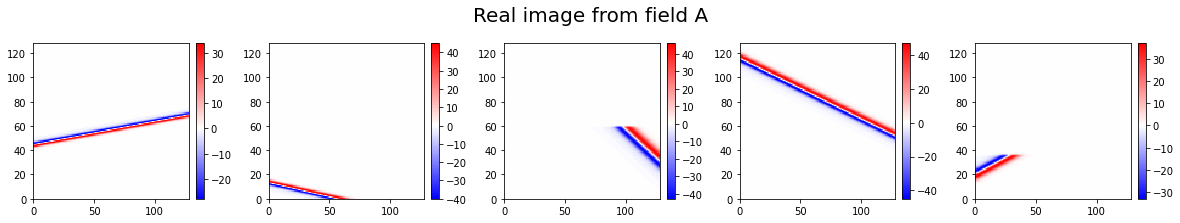

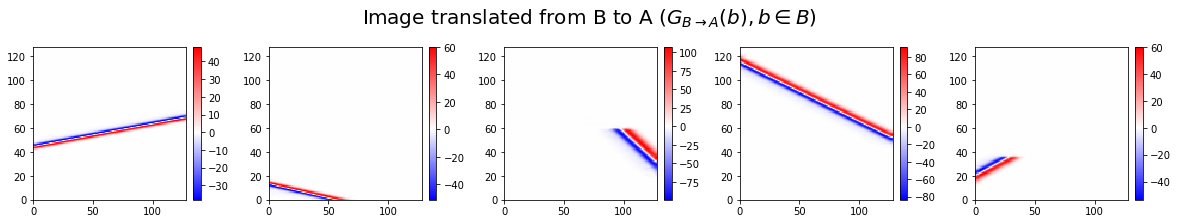

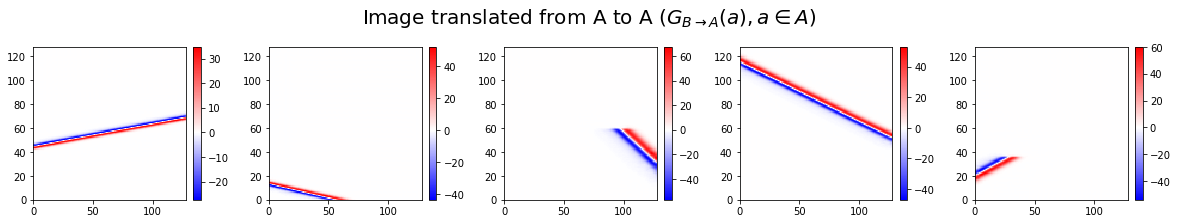

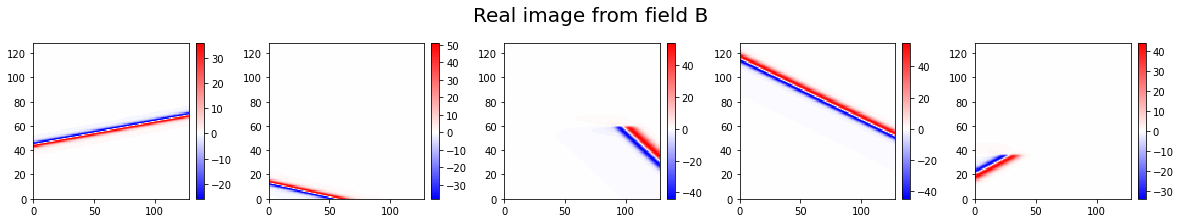

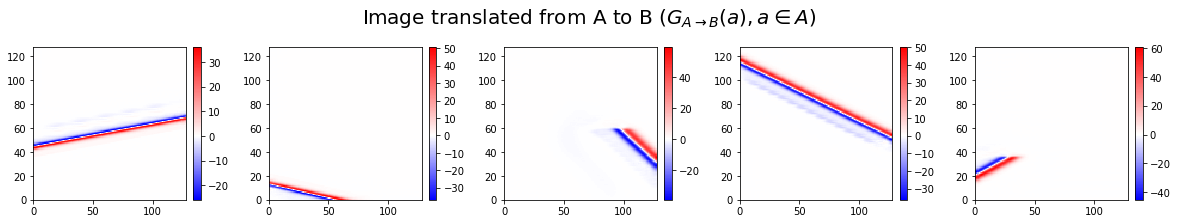

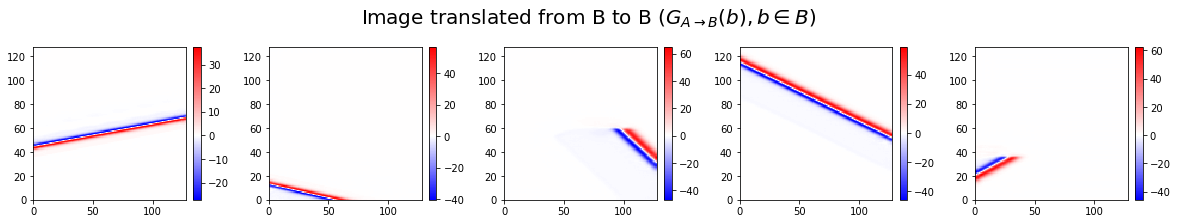

In [22]:
# plot_results(model.get_current_visuals(), num_samples=5)
visuals = get_validation_visuals(model, dataset_valid)
plot_results(visuals, num_samples=5)